In [2]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import create_coherent_state
from core import time_evo
from core import time_evo_new
from core import time_evo_from_state
from core import load_param
from core import load_H_list
from core import load_result
from core import load_tlist
from core import operators
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from core import annihilation_operator
from utils.entropy import compute_VN, plot_VN, compute_VN_time
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.distribution_gif import prob_gif
from utils.distribution_gif import gif_distrib_H_s_int
from utils.distribution_gif import gif_distrib_system_first_eig
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.basic_functions import random_dephasing
from utils.basic_functions import get_state_probabilities
from utils.basic_functions import position
from utils.basic_functions import copy_cat
from utils.basic_functions import plot_einselection
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.interference import interference_plot
from utils.expectations import exp_val_time
from utils.plot_hamiltonians import plot_hamiltonians

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.titlesize'] = 16             # Title font size
plt.rcParams['axes.titleweight'] = 'bold'       # Title font weight
plt.rcParams['axes.labelsize'] = 14             # X and Y label font size
plt.rcParams['axes.labelweight'] = 'bold'       # X and Y label font weight
#plt.rcParams['axes.grid'] = True                # Enable grid
#plt.rcParams['grid.alpha'] = 0.7                # Grid transparency
#plt.rcParams['grid.linestyle'] = '--'           # Grid line style
#plt.rcParams['grid.color'] = 'gray'             # Grid color

# Tick settings
plt.rcParams['xtick.labelsize'] = 12            # X tick label size
plt.rcParams['ytick.labelsize'] = 12            # Y tick label size
plt.rcParams['xtick.direction'] = 'in'          # X tick direction
plt.rcParams['ytick.direction'] = 'in'          # Y tick direction
plt.rcParams['xtick.major.size'] = 6            # X major tick size
plt.rcParams['ytick.major.size'] = 6            # Y major tick size

# Legend settings
plt.rcParams['legend.fontsize'] = 12            # Legend font size
plt.rcParams['legend.frameon'] = True           # Enable legend frame
plt.rcParams['legend.framealpha'] = 0.9         # Legend frame transparency
plt.rcParams['legend.loc'] = 'best'             # Legend location

# Line and marker settings
plt.rcParams['lines.linewidth'] = 2             # Line width
plt.rcParams['lines.markersize'] = 6            # Marker size

custom_colors = ['#1c4587', '#e6194B', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)




<h1>Decoherence, a numerical perspective

The goal of this series of jupyter notebook is to be education on decoherence usin the AC model. So the first one should not focuse on the ACL model, but just introduce decoherence itself. Needs a little bit of preliminary knowledge.

RESSOURCES I AM BASING IT ALL ON. 

Note that these notebooks are based on : Lecture notes on quantum decoherence:Jim Al-Khalili, a bunch of Andreas paper.
Sean Carroll's paper for the basi decoherence example.

PLAN FOR THIS NOTEBOOK:
first introduce quantym entanglement
Need a super simple theoretical toy model of deochernece from which we can calculate a few basic qtt. ie, decoherence time scale
Justification for interest. Coudl do something related to the double slit experiment?
Environment causing entanglement for some states, as a selection of pointer states
ZUrek’s commutativity criterion.
Zurek's random walk and convergence to 0.
2 related problems tackeld by decoherence: Preffered basis, non-visibility of quantum interference (ie, prefe basis and classicality.) what about the unicity of measurement results? i feel like it somehow solves it.


PLAN FOR NEXT NOTEBOOKS:
Can I see Zureks' commutativity criterion in the ACL?
ACL model use to talk about decoherence more.
See if you can modify it to study more usual models of decoherence.
see if you can also go into quatum darwinism.
Multiartide version of what I did?
Idea of locality/decoherence somehow being linked. The interactions are local, but the states can be non-local (ie entanglement). And decoherence is what makes us not see that at our scale. what are all the hints for this link?
Decoherence vs dissipation
Decoherence vs classical noise.



There are many things that we can point to and say, look, thats decoherence

LITTLE TRUTHS I WANT TO INCLUDE

Decoherence solves the measurement problem as well as helps us understand the behavior of open (and not so open) quantum systems
Talk about the einselectyion problem and its solution via pointer states.
Decoherence does not destroy superpositions, it simply extends them to include the environment. So, while decoherence is something that happens to the system of interest, what is really going on is that the environment is encoding, via quantum correlations, information about the system.
decoherence leads to the decay of the off diagonal terms in a basis defined by your system environment interactions. it results from your environment states becoming correlated with the states of your system (i.e. effectively measuring your system)
Basically, the fact that the density matrix diagonalizes in the pointer basis and stay diagonal ensures that we have classicaity in this basis. 
Decoherence as a time asymmetric process.
It causes irreversible loss of coherence from the quantum system 2. It limits/selects a small number of possible observables

For the lengh of this notebook, we consider a universe made of 2 subsystems, $S$ and $E$ the system adn the environment.

Decoherence, in addition to being important to understand for quantum computing provides a partial solution to 3 problems in the foundations of physics.

<h1>What is a quantum measurement?


For our purpous a measurement is an interaction between 2 quantum systems. One large and one small. For it to be an interesting measurement, the small system there must be an increase of entropy as the 2 systems interact. I will sometimes refer to the environment as a measuring device, especially when I want to choose the state it measures.

Considering a system in state $|\psi\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. We also consider a measuring device in state $|READY\rangle$, as it is ready to measure the system. It is such that feeding it state $|0\rangle$ makes it evolve to $|M0\rangle$ (imagine a computer screen displaying a 0). And feeding it a system in the state $|1\rangle$ makes it evolve to $|M1\rangle$.

From these simple rules and the linearity of QM we find that 

$\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)|READY\rangle\rightarrow\frac{1}{\sqrt{2}}|0\rangle|M0\rangle+|1\rangle|M1\rangle$.

Thus without mentionning a measurement, just time evolution we get a system and measuring device in a superposition of 2 states. 0 and having measured 0, with 1 and having measured 1. 

Here we imagined the system making the "environment" evolve, we could imagine both evolving together. The point is we need increasing entropy between both.



/var/folders/ty/2v67w7m97_g8zp6lgsqd1dsr0000gn/T/ipykernel_3397/75512201.py:42: RuntimeWarning: divide by zero encountered in log
  S=-np.trace(rho*np.log(rho))
/var/folders/ty/2v67w7m97_g8zp6lgsqd1dsr0000gn/T/ipykernel_3397/75512201.py:42: RuntimeWarning: invalid value encountered in multiply
  S=-np.trace(rho*np.log(rho))
/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


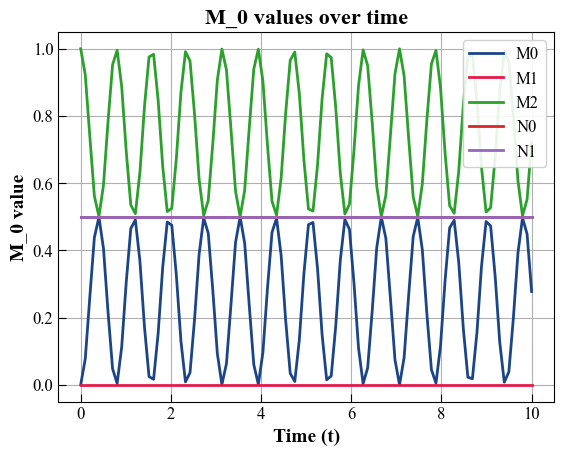

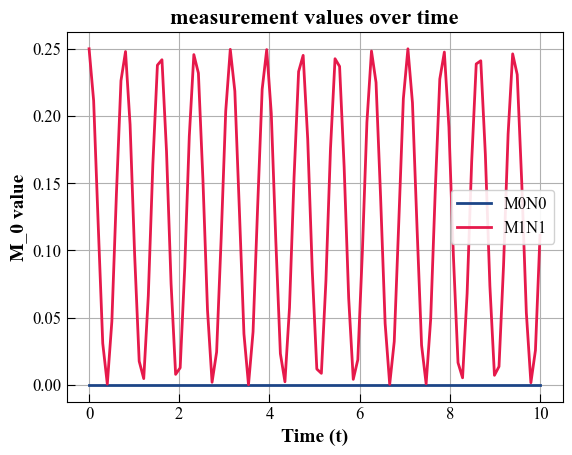

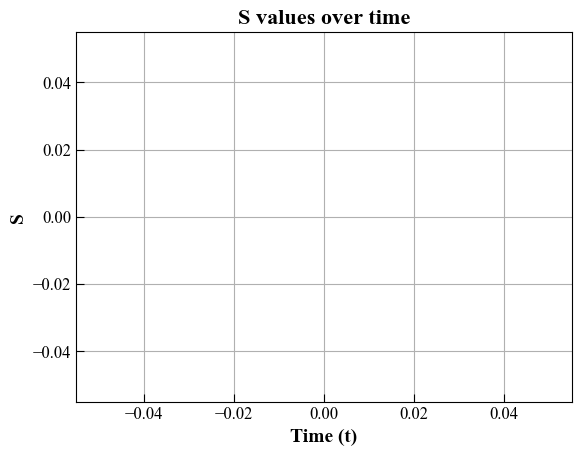

In [37]:
ar = np.array
kr = np.kron
T = np.transpose
out=np.outer
pauli_z=ar([[1,0],[0,-1]])
pauli_y=ar([[0,-1j],[1j,0]])
pauli_x=ar([[0,1],[1,0]])
id=np.identity(2)
id3=np.identity(3)


E1=1
E2=5
lamb=4
q0=ar([1,0])
q1=ar([0,1])
p0=ar([1,0,0])
p1=ar([0,1,0])
p2=ar([0,0,1])

psi_s=(1/np.sqrt(2))*(q0+q1)
psi_m=p2
psi_0=kr(psi_s,psi_m)

H_self=kr(E1*out(q0,q0.conj())+E2*out(q1,q1.conj()),id3)
H_int=-1j*lamb*(kr(out(q0,q0.conj()),(out(p0,p1.conj())-out(p1,p0.conj())))+kr(out(q1,q1.conj()),(out(p0,p2.conj())-out(p2,p0.conj()))))
H_tot=H_self+H_int

from scipy import linalg


def get_Ut(t,H):
    U_t=linalg.expm(-(1j)*t*H)
    return U_t

def get_psi_t(t,psi_0,H):
    Ut=get_Ut(t,H)
    psi_t=Ut@psi_0
    return psi_t

def get_s(rho):
    S=-np.trace(rho*np.log(rho))


M_0=kr(id,out(p0,p0.conj()))
M_1=kr(id,out(p1,p1.conj()))
M_2=kr(id,out(p2,p2.conj()))
N_0=kr(out(q0,q0.conj()),id3)
N_1=kr(out(q1,q1.conj()),id3)
M0N0=0.5*kr(out(q0,q0.conj()),out(p1,p1))
M1N1=0.5*kr(out(q1,q1.conj()),out(p2,p2))

t_list = np.linspace(0, 10, 100)
M_0_list=[]
M_1_list=[]
M_2_list=[]
N_0_list=[]
N_1_list=[]
M0N0_list=[]
M1N1_list=[]
S_list=[]

for t in t_list:
    psi_t=get_psi_t(t,psi_0,H_tot)
    rhot=out(psi_t,psi_t.conj())
    M_0_list.append(np.trace(rhot@M_0))
    M_1_list.append(np.trace(rhot@M_1))
    M_2_list.append(np.trace(rhot@M_2))
    N_0_list.append(np.trace(rhot@N_0))
    N_1_list.append(np.trace(rhot@N_1))
    M0N0_list.append(np.trace(rhot@M0N0))
    M1N1_list.append(np.trace(rhot@M1N1))
    rho_p=np.trace(rhot.reshape(2,3,2,3), axis1=0, axis2=2)
    S_list.append(get_s(rho_p)) #Need to compute the partial trace. 



plt.plot(t_list, M_0_list)
plt.plot(t_list, M_1_list)
plt.plot(t_list, M_2_list)
plt.plot(t_list, N_0_list)
plt.plot(t_list, N_1_list)
plt.xlabel('Time (t)')
plt.ylabel('M_0 value')
plt.title('M_0 values over time')
plt.legend(["M0","M1","M2","N0","N1"])
plt.grid(True)
plt.show()


plt.plot(t_list, M0N0_list)
plt.plot(t_list, M1N1_list)
plt.xlabel('Time (t)')
plt.ylabel('M_0 value')
plt.title('measurement values over time')
plt.legend(["M0N0","M1N1"])
plt.grid(True)
plt.show()

plt.plot(t_list, S_list)
plt.xlabel('Time (t)')
plt.ylabel('S')
plt.title('S values over time')
plt.grid(True)
plt.show()




ADD GRAPH OF ENTROPY.

A fundamental property of decoherence we want to see here is that the environemnt states become orthogonal.  And correspond respectively to the 2 possibel values.

What happens when we make the environment bigger. We consider a slighty different case. The system is still a superposition of 2 states with the same energy (for simplicity), $|\psi(0)\rangle=\sqrt{w}|0\rangle+\sqrt{1-w}|1\rangle$,the total Hamiltonian takes a simple form $H_{tot}=|0\rangle\rangle 0|\otimes H_e^{(1)}+|1\rangle\rangle 1|\otimes H_e^{(2)}$ and the environment is yet undetermined state $|e\rangle$.

This leads to the following time evolution.

\begin{align}
    |\psi(t)\rangle = e^{-itH_{tot}}|\psi(0)\rangle\\
    =e^{-itH_{tot}}|0\rangle\sqrt{w}|e\rangle+e^{-itH_{tot}}|1\rangle\sqrt{1-w}|e\rangle\\
    =|0\rangle\sqrt{w}e^{-it(H_e^{(1)})}|e\rangle+|1\rangle\sqrt{1-w}e^{-it(H_e^{(2)})}|e\rangle\\
    = |0\rangle\sqrt{w}|\mathcal{E}_1(t)\rangle+|1\rangle\sqrt{1-w}|\mathcal{E}_2(t)\rangle\\
\end{align}

Defining $H^{(1)}_e-H^{(2)}_e=H_d$ with spectrum $E_k$. We suppose that the environment state has a uniform distribution in the eigenbasis of $H_d$ and we look at,
\begin{align}
    |r(t)|^2=|\langle \mathcal{E}_1|\mathcal{E}_2\rangle|^2&=|\langle e|e^{-itH_D}|e\rangle|^2\\
    &=\frac{1}{d_2^2}\sum_j\langle j|\sum_ie^{-itE_j}|i\rangle\\
    &=\frac{1}{d_2^2}\sum_{ij} e^{-itE_k}\\
    &=\frac{1}{d_2^2}[d_2+2\sum_{k\geq j}cos(t(E_k-E_j)]\\
\end{align}

To push the theoretical aspect a little further, as in Zurek's seminal paper, we can look at $\langle |r(t)|^2\rangle$,
\begin{align}
    \langle |r(t)|^2\rangle &= \lim_{T\rightarrow \infty}\frac{1}{T}\int^{T}_0|r(t)|^2\\
    &=\lim_{T\rightarrow \infty}\frac{1}{T}\int^{T}_0\frac{1}{d_2^2}[d_2+2\sum_{k\geq j}|c_k|^2|c_j|^2cos(t(E_k-E_j))\\
    &=\frac{1}{d_2}+\lim_{T\rightarrow \infty}\frac{2}{d_2^2}\sum_{k\geq j}|c_k|^2|c_j|^2\frac{sin(T(E_k-E_j))}{T(E_k-E_j)}]\\
    &\propto \frac{1}{d_2}
\end{align}
Which supposing our environment is made up of qubits, we have that $d_2=2^N$, making $|r(t)|^2$ exponentially decreasing in number of qubits forming our environment. 

What we can look at from a numerical pov, is the shape of $|r(t)|^2$. We can do it for a state with a specific spectrum $E_k=k$ and one with the spectrum of a GUE matrix.

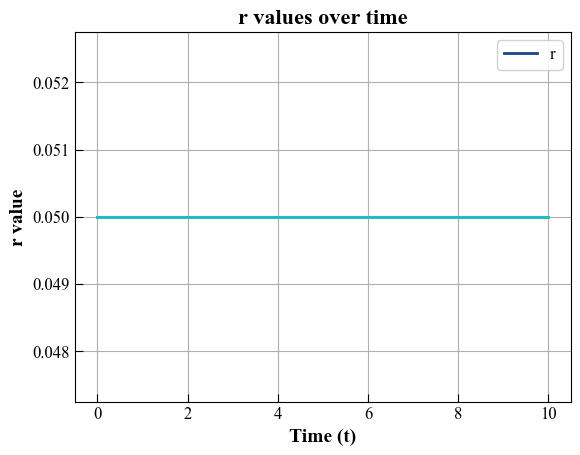

/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


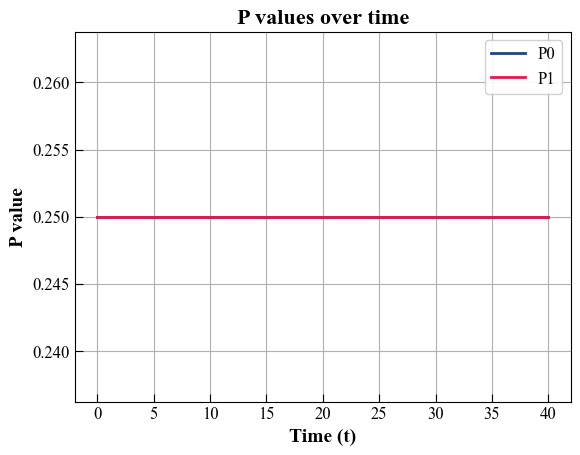

In [46]:
d=10
E_list_k = np.linspace(1, d, d)
H_k=np.diag(E_list_k)
random_list = (np.random.rand(d)*10).tolist()
H_r=np.diag(random_list)

q0=ar([1,0])
q1=ar([0,1])
basis_vectors = []
for i in range(d):
    vector = np.zeros(d)
    vector[i] = 1
    basis_vectors.append(vector)

psi_s=(1/np.sqrt(2))*(q0+q1)
psi_e=1/np.sqrt(d)*sum(basis_vectors)
psi_0=kr(psi_s,psi_e)

id_d=np.identity(d)
id_2=np.identity(2)
Hs=ar([[0.25,0],[0,5]])
H=kr(Hs,H_k)
H2=kr(Hs,H_r)

P0=(1/2)*kr(out(q0,q0.conj()),id_d)
P1=(1/2)*kr(out(q1,q1.conj()),id_d)

t_list = np.linspace(0, 10, 100)
P0_list=[]
P1_list=[]
r_list=[]

for t in t_list:
    psi_t=get_psi_t(t,psi_0,H)
    rhot=out(psi_t,psi_t.conj())
    
    Ep_1=kr(q0.conj(),id_d)@psi_t
    Ep_2=kr(q1.conj(),id_d)@psi_t
    
    P0_list.append(np.trace(rhot@P0))
    P1_list.append(np.trace(rhot@P1))
    r=abs(Ep_1.conj()*Ep_2)

    r_list.append(r)
    
    #S_list.append(get_s(rho_p)) #Need to compute the partial trace. 

plt.plot(t_list, r_list)
plt.xlabel('Time (t)')
plt.ylabel('r value')
plt.title('r values over time')
plt.legend(["r"])
plt.grid(True)
plt.show()

t_list = np.linspace(0, 40, 400)
P0_list=[]
P1_list=[]

for t in t_list:
    psi_t=get_psi_t(t,psi_0,H2)
    rhot=out(psi_t,psi_t.conj())
    P0_list.append(np.trace(rhot@P0))
    P1_list.append(np.trace(rhot@P1))
    #rho_p=np.trace(rhot.reshape(2,d,2,d), axis1=0, axis2=2)
    #S_list.append(get_s(rho_p)) #Need to compute the partial trace. 

plt.plot(t_list, P0_list)
plt.plot(t_list, P1_list)
plt.xlabel('Time (t)')
plt.ylabel('P value')
plt.title('P values over time')
plt.legend(["P0","P1"])
plt.grid(True)
plt.show()




What we observe here is the form of $|r(t)|^2$ we derived above. For a hamilotnian with a random spectrum, we will have a poincare time that is a lot longer, as well as aparently fluctuating values a lot higher than with our clean spectrum

In [ ]:
Does entropy always increase in a measurment?
Of note. We go from a state with 0 entropy to one with ln2


Not here that we where specifying by hand how the measuring device evolves depending on the state of the system, as well as supposing a non-evolving system. But we can also work with an actual hamiltonian and do the evolution that does the measurement for us. This is already touchingr on a fundamenmtal aspect of decohernece as a solution to fondamental problems. Its all unitary QM. No special evolution for the MWs.

<h1>The prefered basis problem

In a basis $\{|i\rangle\}$ the state of the systsem is $|\psi\rangle=\sum_ia_i|i\rangle$. But the Hilbert space of the system does not have any fundamental structure making basis $\{|i\rangle\}$ preferable over some other basis $\{|i'\rangle\}$. And that basis could even be one such that $|\psi\rangle=\sum_ia_i|i\rangle=|0'\rangle$, that is a basis in which we loose the superposition. If that is the case then a lot of quantum mechanics seems meaningless, why not consider the double slit experiment in the basis where the photons are not in a superposition? Does the computational advantage of QM disapeare if we look at our state in another basis? 

Prefered basis as  the reason why Zurek introduces introduces the 3 systems.

An isolated (system+apparatus) duo suffers from the ambiguity of basis choice and observables. An example that Zurek likes to give is how a CNOT gate with system as the control and the apparatus as the target, in {|0⟩,|1⟩} basis, can "flip" so that the apparatus now becomes the control and the system becomes the target in {|+⟩,|−⟩}={|0⟩+|1⟩2√,|0⟩−|1⟩2√} basis. After decoherence we no longer have the freedom in choosing basis, and we are restricted to working with pointer state basis. The apparatus-environment coupling is crucial in determining the form of the pointer state basis.



Einselection

<h1>Where does classicality come from?

Stability of pointer states.

<h1>The unicity of measurement outcomes

Considering the Stern Gerlach experiement to understand 

<h1>Pointer states

When considering a system and an environment that starts in a pure state $|\psi\rangle$. It will stay pure under unitary evolution. But if it starts separable, $|\psi\rangle=|psi_s\rangle|psi_e\rangle$, it will very likely (under non-trivial evolution, ie with $H\neq H_1\otimes H_2$) become a mixed state $|\psi(t)\rangle \sum_{ij} a_i(t)b_j(t)|i\rangle|j\rangle$.

The Schmidt decomposition theorem states that any bipartide state like our system+environment can always be expressed as $|\psi\rangle=\sum_i s_i|s^s_i\rangle|s^e_i\rangle$, where the sum is over the smaller of the 2 spaces. Fundamentally its just SVD.



Pointer states are the basis in which the system diagonalizes under interaction with an environment. Note, is it guaranteed that the system will find a basis in which it is stably diagonal?

Is it always the case that for decoherence we have that pointer states are just asymptotic Schmidt states. If that is the case there seems to be only a need of 2 systems not 3 to determine them. Can i see the 3rd system as fixing the intermediary env basis, and then it has to be a schmidt wrt 2 systems?

Of course the Schmidt decomposition is defined up to a rotation.

In the case of non degeneracy, we have that the coefficients are unique but the basis terms are not. they are up to a phase. ie if we change a |s_s> we must change the corresponding |s_e> by the opposite phase.

where the 𝐴𝑖 are nonnegative real numbers, we can simply move the phase into one of the bases or the other without changing unitarity (so now we have bases |𝜙𝑖⟩ and |𝜓𝑖⟩). These 𝐴𝑖 are unique, but the bases are only unique up to a phase.
This phase dependance does not matter to the definition of the pointer states as measurements on a quantum state are not affected by the phases of orthogonal states.

We can think of them in a simpler way as whatever gets attached to the measuring devices's measurement states, ie the states of the system post measurements.

Why do these 2 definitions coincide? 

Can you find the pointer states without doing the evolution of the state? can you find them by just looking at the system state and the environment state?
Do you really need the 3rd meta environment?

Is there not a lack of freedom in the schmidt states? making the pointer state basis ambiguity wrong?

"Pointer States and Quantum Darwinism with Two-Body Interactions" is also a great source for pointer state explanations.
These conditions become particularly intuitive by considering the original motivation for pointer states. These states are not only immune to the dynamics induced by the interaction with the environment but can also be thought of as states that correspond to the pointer of a measurement apparatus. Mathematically, such an apparatus is described by the pointer observable given by the following equation:

form of H for existance of exact pointer states, But also show that they exist non-exactly!

"These conditions become particularly intuitive by considering the original motivation for pointer states. These states are not only immune to the dynamics induced by the interaction with the environment but can also be thought of as states that correspond to the pointer of a measurement apparatus."
So they are essentially just eigenstates of the interaction Hamiltonian. Are pointer states necessarriy eigenstates of the interaction Hamiltonian? Also you want these eigensates to be separable, else the system part will evolve. 


<h1>Quantum darwinism

Potentially reproduce the results of this paper: Pointer States and Quantum Darwinism with Two-Body Interactions